  <div class="alert alert-info">
  Привет, Евгений! Меня зовут Светлана Чих и я буду проверять твой проект. Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе. Предлагаю общаться на «ты». Но если это не удобно - дай знать, и мы перейдем на «вы».

  <div class="alert alert-success">
  <b>👍 Успех:</b> Зелёным цветом отмечены удачные и элегантные решения, на которые можно опираться в будущих проектах.
  </div>
  <div class="alert alert-warning">
  <b>🤔 Рекомендация:</b> Жёлтым цветом выделено то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно).
  </div>
  <div class="alert alert-danger">
  <b>😔 Необходимо исправить:</b> Красным цветом выделены комментарии, без исправления которых, я не смогу принять проект :(
  </div>
  <div class="alert alert-info">
  <b>👂 Совет:</b> Какие-то дополнительные материалы
  </div>
  Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
  Мне будет легче отследить изменения, если ты выделишь свои комментарии:
  <div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Например, вот так.</div>
  Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта быстрее.
   </div>

# Проект: Прогнозирование температуры звезды

## Описание проекта

Задача от обсерватории «Небо на ладони» с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:


- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.


Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

## Описание данных

- `Temperature (K)` - Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.
- `Luminosity(L/Lo)	` - Относительная светимость L/Lo — светимость звезды относительно Солнца.
- `Radius(R/Ro)` - Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- `Absolute magnitude(Mv)` - Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- `Star type` - Тип звезды.
    - 0 - Коричневый карлик	0
    - 1 - Красный карлик
    - 2 - Белый карлик
    - 3 - Звёзды главной последовательности
    - 4 - Сверхгигант
    - 5 - Гипергигант
- `Star color` - Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

In [1]:
!pip install optuna

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import optuna
from optuna.samplers import TPESampler
import copy
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
import numpy as np

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [4]:
set_seed(25)
sampler = TPESampler(seed=25)

Random seed set as 25


<div class="alert alert-success">
<b>👍 Успех:</b> Импортированы нужные библиотеки!
</div>

## Загрузка данных

In [5]:
df = pd.read_csv('/datasets/6_class.csv', index_col='Unnamed: 0')

In [6]:
def primary_information(df):
    print(f"Размерность: {df.shape}")
    display(df.info())
    display(df.head())

In [7]:
primary_information(df)

Размерность: (240, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


None

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [8]:
df.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [9]:
df[df.duplicated()]

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color


### Промежуточный вывод

Был успешно выгружен датасет, состоящий из 240 записей. Пропуски и полные дубликаты отсутствуют.

<div class="alert alert-success">
<b>👍 Успех:</b> Датасет загружен и просмотрен!
</div>

## Предобработка данных

In [10]:
df['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Blue white              3
Yellowish White         3
yellowish               2
Whitish                 2
Orange                  2
Orange-Red              1
Yellowish               1
Blue white              1
Blue                    1
White-Yellow            1
Blue-White              1
Pale yellow orange      1
Name: Star color, dtype: int64

Поле содержит 19 уникальных значений, некоторые из которых являются дубликатами или по смыслу, или в связи с разным орфографическим написанием. Приведем значения к единому регистру и устраним неявные дубликаты

In [11]:
df['Star color'] = df['Star color'].str.lower().str.replace('-', ' ').str.strip()

In [12]:
df.loc[df['Star color'] == 'white yellow', 'Star color'] = 'yellow white'
df.loc[df['Star color'] == 'yellowish white', 'Star color'] = 'yellow white'
df.loc[df['Star color'] == 'whitish', 'Star color'] = 'white'
df.loc[df['Star color'] == 'yellowish', 'Star color'] = 'other'
df.loc[df['Star color'] == 'pale yellow orange', 'Star color'] = 'other'
df.loc[df['Star color'] == 'orange', 'Star color'] = 'other'
df.loc[df['Star color'] == 'orange red', 'Star color'] = 'other'

In [13]:
df['Star color'].value_counts()

red             112
blue             56
blue white       41
yellow white     12
white            12
other             7
Name: Star color, dtype: int64

Удалось с ократить количество категорий с 19-ти до 6-ти.

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> По Гарвардской классификации у звезд 7 цветов 
    
- Голубой
- Бело-голубой
- Белый
- Жёлто-белый
- Жёлтый
- Оранжевый
- Красный

У тебя странная замена 'pale yellow orange' в 'yellowish', а затем в 'yellow white'. Цвет orange представлен всего 3 звездами, то есть их очень мало и для обучения и для тестирования. Если после изменения преобразований цветов у тебя появятся другие малочисленные цвета, то их лучше объединить в отдельную категорию other, или просто удалить</s>

</div>

  <div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## Анализ данных

In [14]:
target = ['Temperature (K)']
num_col_names = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
cat_col_names = ['Star color', 'Star type']

In [15]:
def draw_boxplots(df, ncols, nrows, boxplot_cols, title):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 8))
    for i in range(len(boxplot_cols)):
        sns.boxplot(data=df, y=boxplot_cols[i], ax=axs[i // ncols][i % ncols])
        axs[i // ncols][i % ncols].set_xlabel(boxplot_cols[i])
        axs[i // ncols][i % ncols].set_ylabel('')
    fig.suptitle(title, fontsize=30);

In [16]:
def show_scatterplot_with_temperature(df, y, columns, cols):
    fig, axs = plt.subplots(ncols=cols, nrows=1, figsize=(18, 4))
    for i in range(len(columns)):
        sns.scatterplot(data=df, x='Temperature (K)', y=y, palette="deep", hue=columns[i], ax=axs[i])
    fig.suptitle(f"Диаграммы рассеяния для {y} и температуры", fontsize=30)
    plt.legend(loc='upper right')

In [17]:
def show_hist(df, columns, cols, title):
    rows = ((len(columns) + cols - 1) // cols)
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(18, 4 * rows))
    for i in range(len(columns)):
        sns.histplot(x = columns[i], data = df, multiple = "dodge", ax=axs[i // cols][i % cols])
    fig.suptitle(title, fontsize=30)

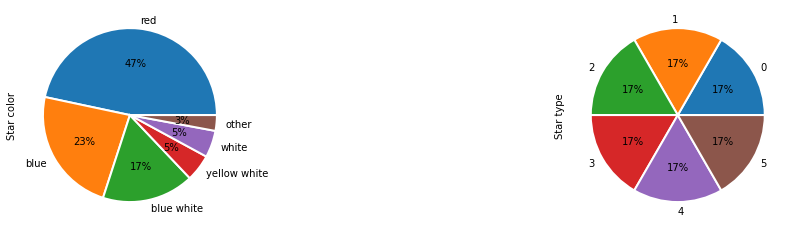

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 4))
df['Star color'].value_counts().plot.pie(
    ax=axs[0], 
    autopct='%1.f%%', 
    legend=False,
    wedgeprops = {
        "edgecolor" : "white",
        'linewidth': 2,
        'antialiased': True
    }
)
df['Star type'].value_counts().plot.pie(
    ax=axs[1],
    autopct='%1.f%%',
    legend=False,
    wedgeprops = {
        "edgecolor" : "white",
        'linewidth': 2,
        'antialiased': True
    }
);

В датасете преобладают звезды с красным свечением, их количество сотсавляет 47% от всего датасета. Тип звезд же распределен равномерно.

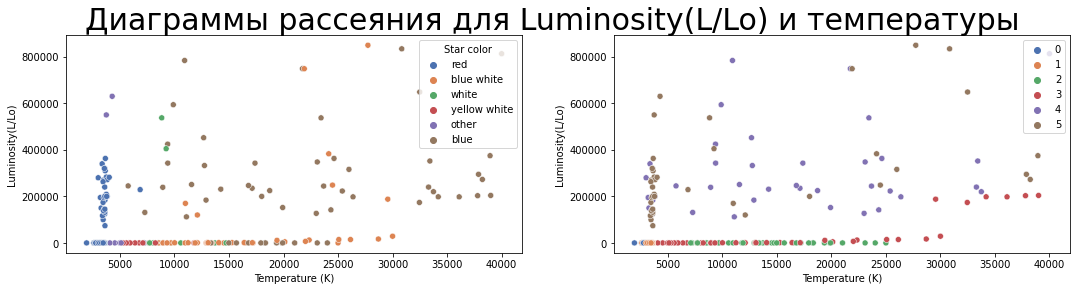

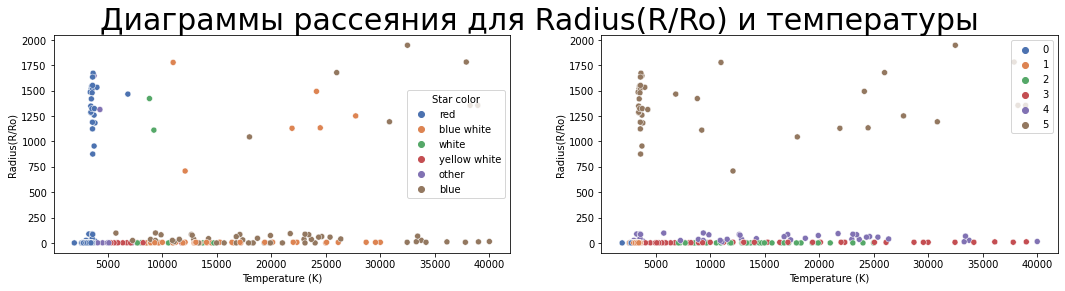

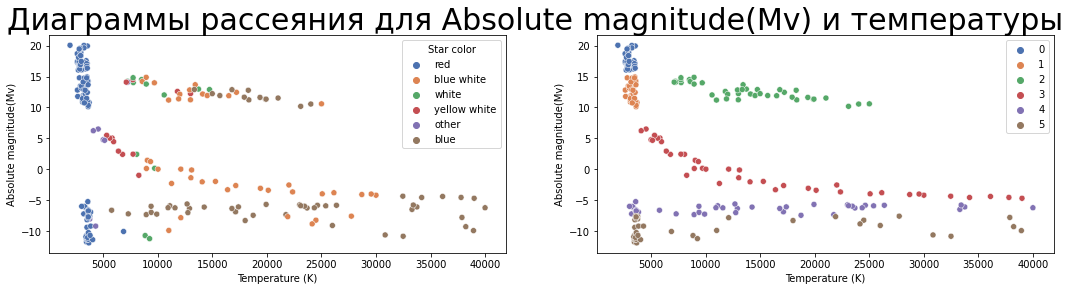

In [19]:
for item in num_col_names:
    show_scatterplot_with_temperature(df, item, cat_col_names, 2)

На диаграммах рассеяния видно, что температура зависит от количественных переменных для разных типов и цветов звезд по разному. Звезды с маленькими температурами преимущественно имеют красное свечение и принадлежат к нулевому, первому и шестому типу. 

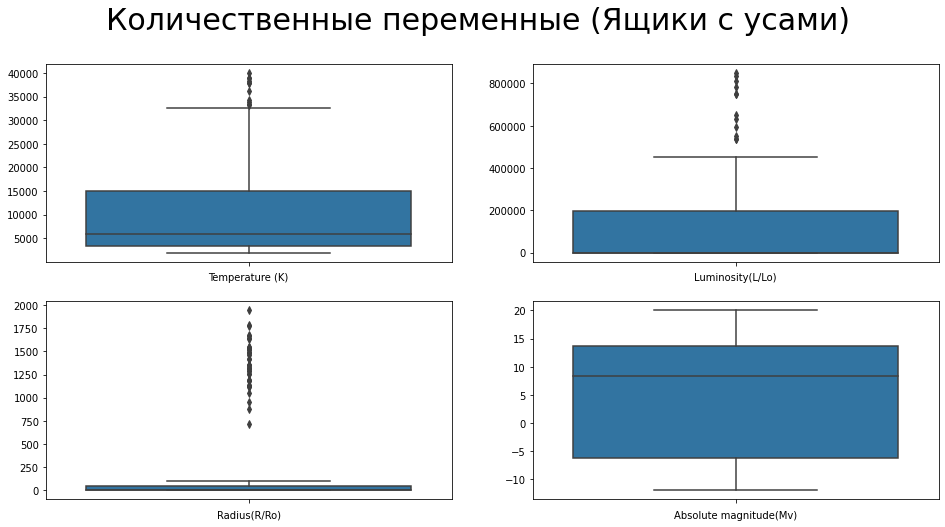

In [20]:
boxplot_cols = [
    'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)'
]
draw_boxplots(df, 2, 2, boxplot_cols, 'Количественные переменные (Ящики с усами)')

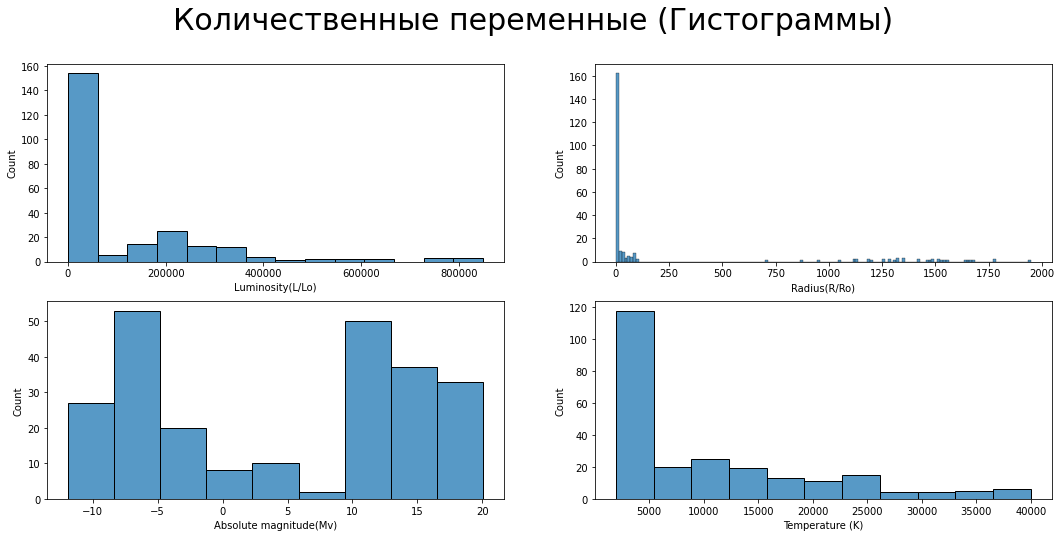

In [21]:
show_hist(
    df, 
    num_col_names + target, 
    2,
    f'Количественные переменные (Гистограммы)'
)

По диаграммам можно сделать вывод, что данные делятся на две группы. Причем группа содержащая звезды с малым радиусом и низкой температурой более многочисленная. Это связано с тем, что датасет наполовину состоит из звезд с красным свечением, а звезды с этим типом свечения обладают низкими значениями температуры.

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> Все графики должны быть оформлены, то есть должен быть заголовок, подписи осей, при необходимости легеда. Нужно провести корреляционный анализ, построить диаграммы рассеяния, разделив даные цветам по типу звезд. Добписать выводы после каждой визуализации и общий вывод по разделу.
    
Исследование и подготовка самих данных это очень важный момент, которым не стоит пренебрегать, от этого часто зависит качество обучения и прогнозирования. </s>
</div>

  <div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Отлично получилось!
</div>

## Построение базовой нейронной сети

In [22]:
scaler = RobustScaler()
encoder = OneHotEncoder()

In [23]:
X_scaled = scaler.fit_transform(df[num_col_names])
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)
X_ohe = encoder.fit_transform(df[cat_col_names]).toarray()
encoder_col_names = encoder.get_feature_names() 
X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X = pd.concat([X_ohe, X_scaled], axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    df['Temperature (K)'],
    test_size=0.25,
    shuffle=True,
    random_state=25)

X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [25]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3) 
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons) 
    
    def forward(self, x):
        out = self.fc1(x)
        out = torch.relu(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = self.fc3(out)
        out = torch.relu(out)
        out = self.fc4(out)
        out = torch.relu(out)
        
        return out

In [26]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 12
n_hidden_neurons_2 = 8
n_hidden_neurons_3 = 4
n_out_neurons = 1

In [27]:
lr=0.001
num_epochs = 10000
per_epochs = 100

In [28]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [29]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

loss = RMSELoss
rmse_min = float('inf')
best_params = None

for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    loss_value = loss(preds, y_train)
    loss_value.backward()
    optimizer.step()

    if epoch % per_epochs == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test).flatten()
        rmse = loss(test_preds, y_test)
        if rmse_min > rmse:
            rmse_min = rmse
            best_params = copy.deepcopy(net.state_dict())

In [30]:
best_basic_rmse = rmse_min
print(f"Лучшая метрика: {best_basic_rmse:.0f}")

Лучшая метрика: 3059


Text(0.5, 0, 'Звезда')

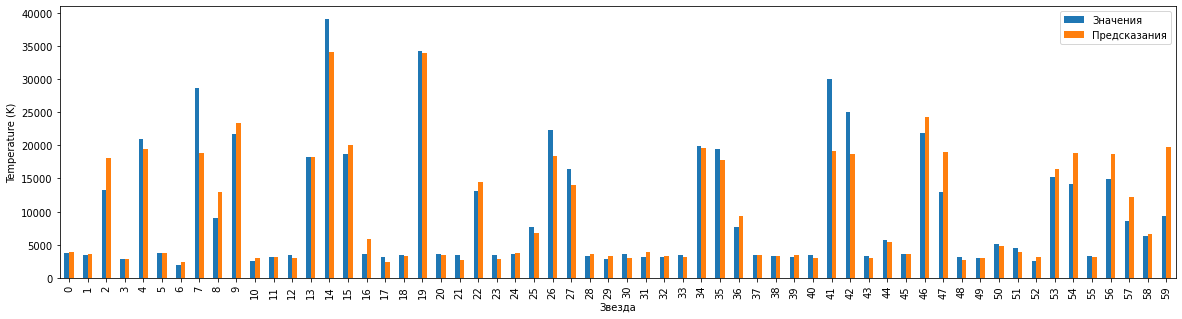

In [31]:
net.load_state_dict(best_params)
test_preds = net.forward(X_test).flatten()
y_test_df = pd.DataFrame(y_test.detach().numpy())
test_preds_df = pd.DataFrame(test_preds.detach().numpy())
res_df = pd.concat([y_test_df, test_preds_df], axis=1)
fig = res_df.plot(kind='bar', figsize=(20, 5))
fig.legend(['Значения', 'Предсказания'])
fig.set_ylabel('Temperature (K)')
fig.set_xlabel('Звезда')

Можно увидеть, что на маленькие значения температуры сеть предсказывает более точно, в сравнении с большими значениями. Объяснить это можно тем, что датасет состоит из маленького количество данных и преимущественно содержит записи звезд с маленькими температурами, поэтому сеть на этих данных лучше обучилась.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## Улучшение нейронной сети

Создадим класс нейросети с гиперпараметрами

In [32]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons, 
                 dp1, dp2, dp3, bn1en, bn2en, bn3en):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1en = bn1en
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=dp1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.bn2en = bn2en
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=dp2)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3) 
        self.bn3en = bn3en
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)
        self.dp3 = nn.Dropout(p=dp3)
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons) 
    
    def forward(self, x):
        out = self.fc1(x)
        if self.bn1en:
            out = self.bn1(out)
        out = torch.relu(out)
        out = self.dp1(out)
        out = self.fc2(out)
        if self.bn2en:
            out = self.bn2(out)
        out = torch.relu(out)
        out = self.dp2(out)
        out = self.fc3(out)
        if self.bn3en:
            out = self.bn3(out)
        out = torch.relu(out)
        out = self.dp3(out)
        out = self.fc4(out)
        out = torch.relu(out)
        
        return out

In [33]:
def objective(trial):
    # Гиперпараметры для настройки
    dp1 = trial.suggest_float('dp1', 0.5, 0.8, step=0.1)
    dp2 = trial.suggest_float('dp2', 0.5, 0.8, step=0.1)
    dp3 = trial.suggest_float('dp3', 0.5, 0.8, step=0.1)
    bn1en = trial.suggest_categorical('bn1en', [True, False])
    bn2en = trial.suggest_categorical('bn2en', [True, False])
    bn3en = trial.suggest_categorical('bn3en', [True, False])
    
    net = Net(n_in_neurons, 
              n_hidden_neurons_1, 
              n_hidden_neurons_2, 
              n_hidden_neurons_3, 
              n_out_neurons, 
              dp1, 
              dp2, 
              dp3,
              bn1en,
              bn2en,
              bn3en)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = RMSELoss
    rmse_min = float('inf')
    best_params = None

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = net.forward(X_train).flatten()
        loss_value = loss(preds, y_train)
        loss_value.backward()
        optimizer.step()

        if epoch % per_epochs == 0 or epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test).flatten()
            rmse = loss(test_preds, y_test)
            # Сохраним лучший результат
            if rmse_min > rmse:
                rmse_min = rmse
                best_params = copy.deepcopy(net.state_dict())
            # Ранняя остановка
            if rmse - rmse_min > 100:
                break
    
    net.load_state_dict(best_params)
    return rmse_min

In [34]:
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=10)
print("Лучшая метрика:", study.best_value)
print("Лучшие гиперпараметры:", study.best_params)

[I 2024-09-28 12:37:20,546] A new study created in memory with name: no-name-14e2c511-6ef1-41f2-aec5-44a8f1d6f08e
[I 2024-09-28 12:38:06,249] Trial 0 finished with value: 3347.8017578125 and parameters: {'dp1': 0.8, 'dp2': 0.7, 'dp3': 0.6, 'bn1en': False, 'bn2en': False, 'bn3en': False}. Best is trial 0 with value: 3347.8017578125.
[I 2024-09-28 12:38:51,649] Trial 1 finished with value: 3116.631103515625 and parameters: {'dp1': 0.6, 'dp2': 0.6, 'dp3': 0.5, 'bn1en': False, 'bn2en': False, 'bn3en': False}. Best is trial 1 with value: 3116.631103515625.
[I 2024-09-28 12:39:47,760] Trial 2 finished with value: 2382.104736328125 and parameters: {'dp1': 0.6, 'dp2': 0.8, 'dp3': 0.6, 'bn1en': True, 'bn2en': True, 'bn3en': True}. Best is trial 2 with value: 2382.104736328125.
[I 2024-09-28 12:40:42,467] Trial 3 finished with value: 13332.564453125 and parameters: {'dp1': 0.7, 'dp2': 0.6, 'dp3': 0.6, 'bn1en': False, 'bn2en': True, 'bn3en': False}. Best is trial 2 with value: 2382.104736328125.


Лучшая метрика: 2382.104736328125
Лучшие гиперпараметры: {'dp1': 0.6, 'dp2': 0.8, 'dp3': 0.6, 'bn1en': True, 'bn2en': True, 'bn3en': True}


Обучим сеть с лучшими гиперпараметрами:

In [35]:
best_dp1 = study.best_trial.params['dp1']
best_dp2 = study.best_trial.params['dp2']
best_dp3 = study.best_trial.params['dp3']
best_bn1en = study.best_trial.params['bn1en']
best_bn2en = study.best_trial.params['bn2en']
best_bn3en = study.best_trial.params['bn3en']

net = Net(
    n_in_neurons, 
    n_hidden_neurons_1, 
    n_hidden_neurons_2, 
    n_hidden_neurons_3, 
    n_out_neurons, 
    best_dp1, 
    best_dp2, 
    best_dp3,
    best_bn1en,
    best_bn2en,
    best_bn3en)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = RMSELoss
rmse_min = float('inf')
best_params = None

for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    loss_value = loss(preds, y_train)
    loss_value.backward()
    optimizer.step()

    if epoch % per_epochs == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test).flatten()
        rmse = loss(test_preds, y_test)
        # Сохраним лучший результат
        if rmse_min > rmse:
            rmse_min = rmse
            best_params = copy.deepcopy(net.state_dict())
        # Ранняя остановка
        if rmse - rmse_min > 100:
            break
print(f"Лучшая метрика: {rmse_min:.0f}")

Лучшая метрика: 2517


<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> Здесь что-то не так с метрикой, для воспроизводимости нужно зафиксировать случайные значения. После построения графика факт-прогноз нужно сравнить его с предыдущим (что стало лучше, что хуже, что так и осталось)</s>
</div>

  <div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

Text(0.5, 0, 'Звезда')

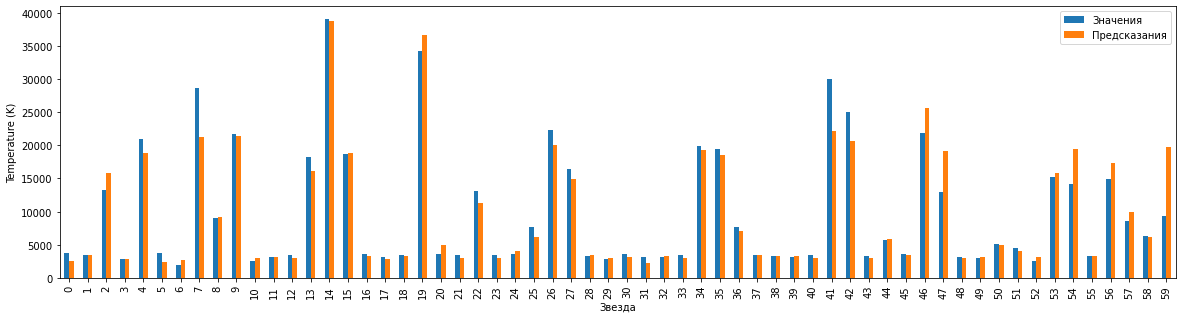

In [36]:
net.load_state_dict(best_params)
test_preds = net.forward(X_test).flatten()
y_test_df = pd.DataFrame(y_test.detach().numpy())
test_preds_df = pd.DataFrame(test_preds.detach().numpy())
res_df = pd.concat([y_test_df, test_preds_df], axis=1)
fig = res_df.plot(kind='bar', figsize=(20, 5))
fig.legend(['Значения', 'Предсказания'])
fig.set_ylabel('Temperature (K)')
fig.set_xlabel('Звезда')

По графику факт-прогноз улучшеной модели можно сделать вывод, что модель стала еще лучше предсказывать малые значения тмпературы, однако, на больших значениях все еще ошибается достаточно сильно, что объясняется недостатком данных для данной группы звезд.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## Выводы
Был успешно выгружен датасет, состоящий из 240 записей и следующих полей:
- `Temperature (K)` - Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.
- `Luminosity(L/Lo)	` - Относительная светимость L/Lo — светимость звезды относительно Солнца.
- `Radius(R/Ro)` - Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- `Absolute magnitude(Mv)` - Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- `Star type` - Тип звезды.
- `Star color` - Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

Первичный анализ показал, что пропуски и полные дубликаты отсутствуют. При более подробном анализе были обнаружены и устранены неявные дубликаты. 

Построенные диаграммы показали, что данные делятся на две группы. Причем группа содержащая звезды с малым радиусом и низкой температурой более многочисленная.

Далее было вполнено кодирование категориальных и шкалирование количественных данных. Датасет был разбит на тренировочную и  тестовую выборки.

Следующим шагом было построение базовой нейросети. Было принято решение использовать три скрытых слоя и функцию активацию ReLu. Обученная сеть показала метрику RMSE соответствующую ТЗ. При сравнении тестовых значений с предсказанными нейросетью видно, что маленькие значения температуры сеть предсказывает более точно, в сравнении с большими значениями. Объяснить это можно тем, что датасет состоит из маленького количество данных и преимущественно содержит записи звезд с маленькими температурами, поэтому сеть на этих данных лучше обучилась, а на больших температурах сильнее ошибается.

Построение улучшенной нейросети с перебором гиперпараметров Dropout и BatchNorm на базе базовой НС позволило получить еще лучший результат метрики. Однако, на больших значениях все еще ошибается достаточно сильно, что объясняется недостатком данных для данной группы звезд.

Для улучшения достоверности предсказания можно порекомендовать собрать датасет побольше или использовать аугментацию данных, но это уже выходит за рамки данного проекта.

<div class="alert alert-success">
<b>👍 Успех:</b> Отличная работа! Было очень приятно проверять твой проект!

Оставлю хороший учебник по ML:
+  https://academy.yandex.ru/handbook/ml

Немного новостей с мира DL(вдруг заинтересует):
+  https://habr.com/ru/company/ods/blog/686962/

Вот тут проходят всякие соревнования, можешь себя попробовать:
+  https://hacks-ai.ru/


Возможно, что нить пригодится:
+  https://arxiv.org/ftp/arxiv/papers/2201/2201.00650.pdf
+  https://github.com/slgero/testovoe


Курс от МФТИ математика для DS:

+  https://www.youtube.com/watch?v=xccjt6lOoow&list=PLk4h7dmY2eYHHTyfLyrl7HmP-H3mMAW08&index=1


Тут много соревнований/лекций:

+  https://ods.ai/

stepic NLP/CV:

+  https://stepik.org/course/54098/syllabus
+  https://stepik.org/course/50352/syllabus

Еще есть от ВШЭ:

+  https://www.youtube.com/watch?v=mwjQaNt8qxk&list=PLEwK9wdS5g0og-DcF1apxutSM0GDLHz_3&ab_channel=%D0%A4%D0%9A%D0%9D%D0%92%D0%A8%D0%AD%E2%80%94%D0%B4%D0%B8%D1%81%D1%82%D0%B0%D0%BD%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5%D0%B7%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D1%8F
+  https://github.com/hse-ds/iad-deep-learning

Удачи в следующих проектах!!!
</div>
